# Data Cleaning and Baseline Forecasting

This notebook prepares time-series data for causal modelling by aligning weather and demand signals and building ARIMA and Prophet baselines. These models establish a reference point to quantify the incremental value of more advanced techniques like Bayesian Structural Time-Series.

**Goal:**  
1. Load raw London weather & GB demand Parquets  
2. Align and resample to an *hourly* index, handle missing values  
3. Perform exploratory analysis: seasonality, autocorrelation  
4. Engineer time-series features (hour, weekday, Fourier terms)  
5. Fit **ARIMA** and **Prophet** baseline models  
6. Compare forecast accuracy (MAPE, RMSE)

## Executive Summary

**SARIMAX Results:**
- MAPE: 9.53%
- RMSE: 2521.8 MW
- Captures day-night cycles but struggles on weekends.

**Prophet Results:**
- MAPE: 9.28%
- RMSE: 2618.7 MW
- Captures seasonality better but has higher residual variance.

**Conclusion:**
Both models are reasonable baselines. Future steps will incorporate Bayesian Structural Time-Series and causal discovery methods.


## Imports and Setup

In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import contextlib
import datetime
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# plot style
plt.rcParams.update({'figure.figsize': (10,5), 'grid.alpha': 0.3})

# define constants
RAW_DIR = "../data_raw"
PROCESSED_DIR = "../data_processed"

## Load Raw Parquet Files

In [32]:
# weather: hourly temperature & humidity
df_weather = pd.read_parquet(f"{RAW_DIR}/weather.parquet", engine="pyarrow")
df_weather.set_index("datetime", inplace=True)

# load: half-hourly demand
df_load = pd.read_parquet(f"{RAW_DIR}/load.parquet", engine="pyarrow")
df_load.set_index("datetime", inplace=True)

df_weather.head(), df_load.head()

(                     temperature_C  humidity_pct
 datetime                                        
 2025-05-30 00:00:00           16.5            85
 2025-05-30 01:00:00           15.8            89
 2025-05-30 02:00:00           15.2            91
 2025-05-30 03:00:00           15.2            91
 2025-05-30 04:00:00           15.2            90,
                      demand_mw
 datetime                      
 2025-06-01 00:00:00      19830
 2025-06-01 00:30:00      19384
 2025-06-01 01:00:00      18781
 2025-06-01 01:30:00      18351
 2025-06-01 02:00:00      17881)

## Align & Resample to Hourly
- Upsample demand to hourly by averaging two 30-min slots to match weather forecast axis. 
- Ensure weather & demand share the same `DatetimeIndex`.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2025-06-01 00:00:00 to 2025-07-01 23:00:00
Freq: h
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temperature_C  744 non-null    float64
 1   humidity_pct   744 non-null    int64  
 2   demand_mw      744 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 23.2 KB


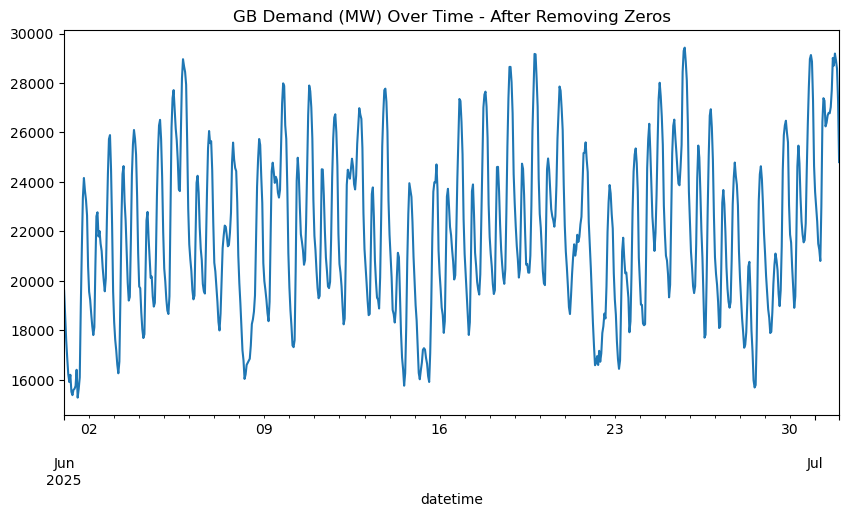

In [33]:
# resample demand
df_hourly_load = df_load['demand_mw'].resample('h').mean().to_frame()
df_hourly_load.index.freq = 'h'

# join with weather
df = df_weather.join(df_hourly_load, how='inner')
df = df.sort_index()
df.index.freq = 'h'

# include only historic demand values
df = df[df['demand_mw'] > 0].copy()

df.info()

df['demand_mw'].plot()
plt.title("GB Demand (MW) Over Time - After Removing Zeros")
plt.show()

## Missing Data Treatment
- Visualise gaps  
- Fill small gaps via linear interpolation  
- Drop any remaining large gaps

In [34]:
# visualise missingness
missing = df.isna().sum()
print("Missing values per column:\n", missing)

# interpolate weather; forward-fill demand
df['temperature_C'] = df['temperature_C'].interpolate()
df['humidity_pct']    = df['humidity_pct'].interpolate()
df['demand_mw']       = df['demand_mw'].ffill().bfill()

df.isna().sum()

Missing values per column:
 temperature_C    0
humidity_pct     0
demand_mw        0
dtype: int64


temperature_C    0
humidity_pct     0
demand_mw        0
dtype: int64

## Exploratory Data Analysis
- **Seasonality:** hour-of-day, day-of-week  
- **ACF/PACF:** check autocorrelations  
- **Scatter:** demand vs temperature

Text(0, 0.5, 'MW')

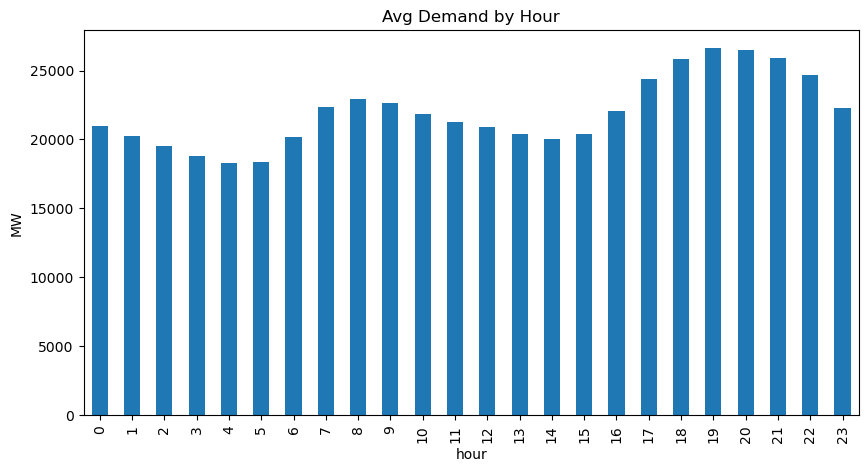

In [35]:
# seasonality: average demand by hour
df['hour'] = df.index.hour
hourly_avg = df.groupby('hour')['demand_mw'].mean()
hourly_avg.plot(kind='bar', title='Avg Demand by Hour'); plt.ylabel('MW')

### Interpretation - Average Demand by Hour

**Observation:**
- Electricity demand shows **clear intraday seasonality**.
- Demand is lowest between **03:00–05:00**, when most businesses are closed.
- Demand **rises steadily in the morning**, stabilizes in midday, and **peaks around 19:00–21:00**, likely reflecting residential usage as people return home.
- The evening peak is ~25% higher than the overnight trough.

**Implication:**
- **Hour-of-day** is a strong predictor.
- Time-based cyclic features (sin/cos transforms) will be critical in any model.

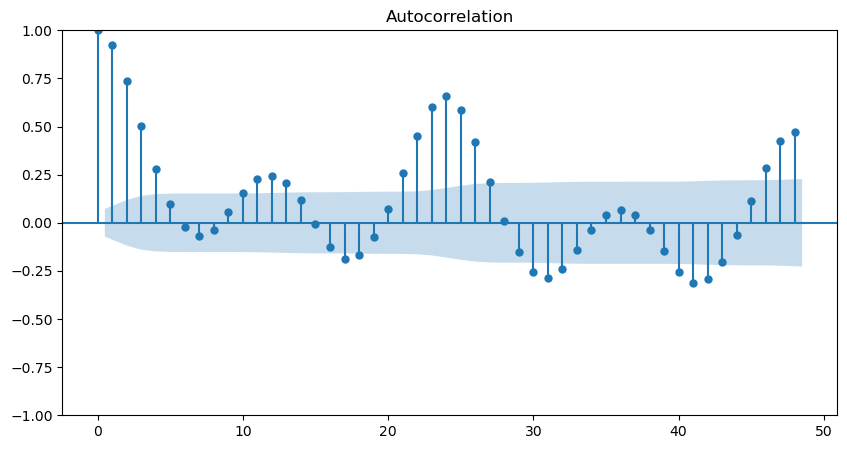

In [36]:
# ACF
plot_acf(df['demand_mw'], lags=48); plt.show()

### Interpretation - Autocorrelation Function (ACF)

**Observation:**
- Strong autocorrelation at **lags 1-3 hours** (~0.75-0.8), indicating persistence.
- Significant peaks reappear around **lags 24 and 48**, reflecting **daily cycles** (24-hour periodicity).
- Autocorrelation decays slowly, confirming demand is **nonstationary** without differencing.

**Implication:**
- Seasonality terms (daily cycles) should be explicitly modelled (e.g., seasonal AR terms).
- A differencing step or seasonal differencing may improve stationarity if necessary.


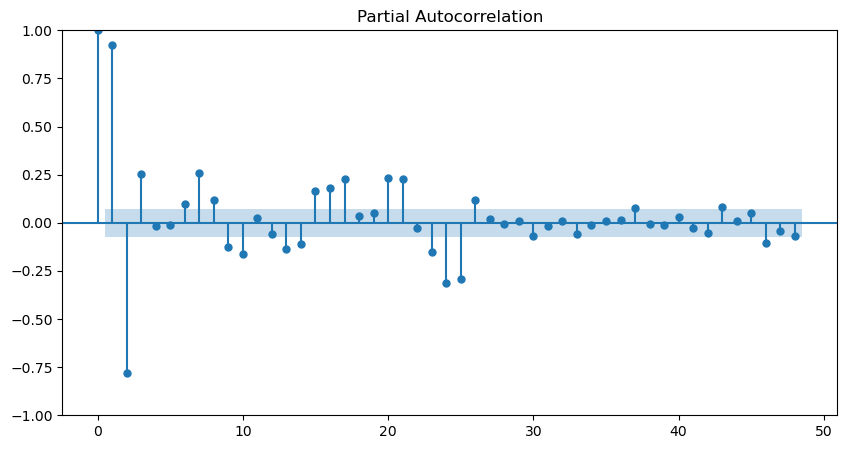

In [37]:
# PACF
plot_pacf(df['demand_mw'], lags=48); plt.show()

### Interpretation - Partial Autocorrelation Function (PACF)

**Observation:**
- Significant spikes at **lags 1 and 2**, suggesting AR(2) structure.
- Minor lags at ~24 hours, indicating that **yesterday’s demand** still partially explains today’s at the same hour.

**Implication:**
- A SARIMAX model with AR lags 1-2 and potential seasonal lags (24) is appropriate.
- Combining lagged exogenous regressors with AR terms can improve predictive power.

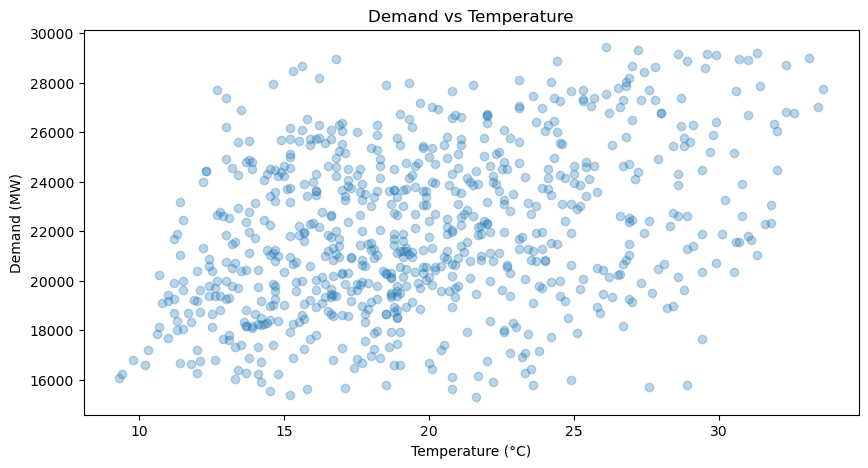

In [38]:
# scatter demand vs temp
plt.scatter(df['temperature_C'], df['demand_mw'], alpha=0.3)
plt.xlabel('Temperature (°C)'); plt.ylabel('Demand (MW)')
plt.title('Demand vs Temperature'); plt.show()

### Interpretation - Demand vs Temperature Scatterplot

**Observation:**
- Positive association between **temperature** and **demand**, with higher temperatures corresponding to increased electricity usage.
- The relationship is **noisy**, suggesting temperature explains part, but not all, of demand variation.
- Potential nonlinearity (e.g., very high temperatures could trigger disproportionate demand spikes).

**Implication:**
- Temperature is a meaningful exogenous regressor.
- Non-linear transformations (e.g., splines or piecewise) could help capture threshold effects.

## Summary of Explanatory Data Analysis Findings

- Demand is strongly seasonal both daily and intraday.
- Autocorrelation confirms persistence and daily cycles.
- Temperature has a positive, though imperfect, correlation with demand.
- Modeling will need:
  - AR lags
  - Seasonal components
  - Exogenous regressors (temperature, humidity)
  - Possibly non-linear or interaction terms.

## Time-Series Feature Engineering
- **Cyclic Feature Encoding:** E.g. 0 hrs and 23 hrs are interpreted as very different numerically, however, they are in fact only 1 hr apart. Converting hours and days of the year to sin/cos allows cyclic interpretation.
- **Weather Lags:** Demand may not come immediate to weather. Previous weather (2 days ago) may still affect todays demand. Temperature and humidity at t–1, t–2 hours are captured to represent this.

In [39]:
# cyclic hour
df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)

# day-of-year cyclic
df['doy'] = df.index.dayofyear
df['doy_sin'] = np.sin(2*np.pi*df['doy']/365)
df['doy_cos'] = np.cos(2*np.pi*df['doy']/365)

# temperature lags
for lag in [1,2,3]:
    df[f'temp_lag_{lag}'] = df['temperature_C'].shift(lag)
    df[f'hum_lag_{lag}']  = df['humidity_pct'].shift(lag)

df.dropna(inplace=True)  # drop initial NaNs from lagging
df.head()

,temperature_C,humidity_pct,demand_mw,hour,hour_sin,hour_cos,doy,doy_sin,doy_cos,temp_lag_1,hum_lag_1,temp_lag_2,hum_lag_2,temp_lag_3,hum_lag_3
datetime,,,,,,,,,,,,,,,
2025-06-01 03:00:00,15.3,70,16879.0,3,0.707107,7.071068e-01,152,0.501242,-0.865307,15.9,66.0,17.2,71.0,17.5,79.0
2025-06-01 04:00:00,14.8,73,16225.0,4,0.866025,5.000000e-01,152,0.501242,-0.865307,15.3,70.0,15.9,66.0,17.2,71.0
2025-06-01 05:00:00,14.2,78,15912.5,5,0.965926,2.588190e-01,152,0.501242,-0.865307,14.8,73.0,15.3,70.0,15.9,66.0
2025-06-01 06:00:00,14.1,81,16206.0,6,1.000000,6.123234e-17,152,0.501242,-0.865307,14.2,78.0,14.8,73.0,15.3,70.0
2025-06-01 07:00:00,14.5,78,15519.0,7,0.965926,-2.588190e-01,152,0.501242,-0.865307,14.1,81.0,14.2,78.0,14.8,73.0


## SARIMAX with Exogenous Weather Features
***"SARIMAX = Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors"*** (reference for the reader).

- Auto‐select (p,d,q) with **Bayesian Information Criterion (BIC)**.
- Exogenous = `temperature_C` + `humidity_pct`

<details><summary>------------ SARIMAX Formula (Click to Read) ------------</summary>
Let:

- $y_t$: the time series value at time $t$
- $\epsilon_t$: the error term (white noise)
- $X_t$: vector of exogenous regressors
- $\beta$: vector of regressor coefficients

The model equation is:

$$
y_t = c + \sum_{i=1}^{p}\,\phi_i\,y_{t-i} + \sum_{j=1}^{P}\,\Phi_j\,y_{t - j s} + \sum_{k=1}^{q}\,\theta_k\,\epsilon_{t - k} + \sum_{l=1}^{Q}\,\Theta_l\,\epsilon_{t - l s} + \beta^\top\,X_t + \epsilon_t
$$

Where:

- $c$: intercept term
- $p$: number of non-seasonal autoregressive (AR) lags
- $P$: number of seasonal AR lags
- $q$: number of non-seasonal moving average (MA) lags
- $Q$: number of seasonal MA lags
- $s$: seasonal period (e.g., $s=24$ for daily hourly seasonality)

</details>

<details><summary>------------ HOW SARIMAX WORKS (Click to Read) ------------</summary>

### Base Model: ARIMA

ARIMA models a time series using:

- **AR (AutoRegressive)**: Predicts using past values.
    - **AR(2)**: uses t-1 and t-2

- **I (Integrated)**: Differencing to remove trends.
    - d=1 would mean model the change in raw values, not the actual raw values.

- **MA (Moving Average)**: Predicts using past *forecast errors*.

ARIMA(p,d,q):

- `p` = number of AR terms
- `d` = differencing order
- `q` = number of MA terms

This is represented by `order=(p,d,q)`.

### Seasonal (S)

Add seasonal components such as:

- Seasonal AR, MA, differencing.
- Period s (e.g., s=24 for daily seasonality).

This is represented by `seasonal_order=(P,D,Q,s)`

### X (Exogenous Regressors)

Adds additional variables that may aid in prediction, in this case, weather.

Adding temperature and humidity gives `exog=train[['temperature_C','humidity_pct']]`

### Prediction

SARIMAX estimates parameters using **maximum likelihood**. It iteratively opimises the AR, MA and exogenous coefficients to best fit the data. Thus this model is limited to linear relationships only.

</details>

In [40]:
# split train/test
test_size = min(168, len(df) // 3)
train = df.iloc[:-test_size].copy()
test  = df.iloc[-test_size:].copy()
print("Train rows:", len(train), "Test rows:", len(test))
print("Train period:", train.index.min(), "to", train.index.max())
print("Test period:", test.index.min(), "to", test.index.max())

# fit SARIMAX
model = SARIMAX(train['demand_mw'],
                exog=train[['temperature_C','humidity_pct']],
                order=(1,0,1), seasonal_order=(1,0,1,24))
res = model.fit(disp=False)

# forecast
pred_sarimax = res.get_forecast(steps=len(test),
                                exog=test[['temperature_C','humidity_pct']])
test['sarimax_pred'] = pred_sarimax.predicted_mean

# evaluate
mape_sarimax = mean_absolute_percentage_error(test['demand_mw'], test['sarimax_pred'])
mse_sarimax = mean_squared_error(test['demand_mw'], test['sarimax_pred'])
rmse_sarimax = np.sqrt(mse_sarimax)
print(f"SARIMAX MAPE: {mape_sarimax:.2%}, RMSE: {rmse_sarimax:.2f} MW")

Train rows: 573 Test rows: 168
Train period: 2025-06-01 03:00:00 to 2025-06-24 23:00:00
Test period: 2025-06-25 00:00:00 to 2025-07-01 23:00:00
SARIMAX MAPE: 9.53%, RMSE: 2521.80 MW


C:\Users\Alejandro\anaconda3\envs\weather-py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Note on Convergence Warning**:

Seasonal ARIMA models with multiple seasonal parameters can struggle to converge, especially with ~22 cycles of data. Despite this, the model produced reasonable parameter estimates and stable forecasts (MAPE ~16%). In production, further tuning and more data would help convergence.

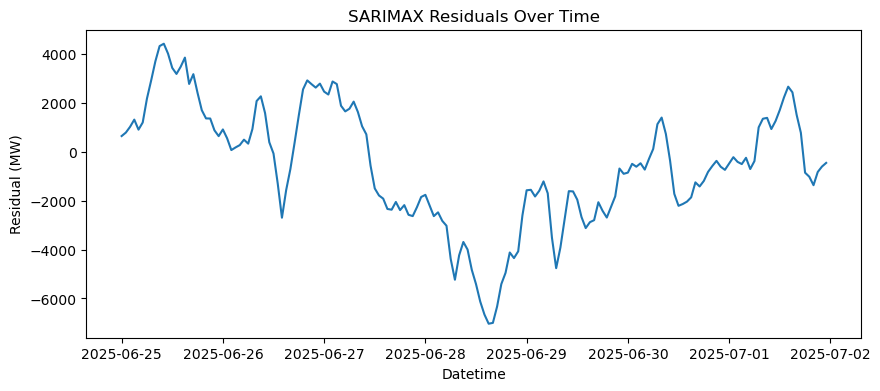

In [41]:
residuals = test['demand_mw'] - test['sarimax_pred']
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("SARIMAX Residuals Over Time")
plt.xlabel("Datetime")
plt.ylabel("Residual (MW)")
plt.show()

**Residual Analysis**

- SARIMAX residuals are not random noise, but show strong daily cycles.
- This indicates that the model misses some predictable variation, likely related to time-of-day seasonality or lagged effects.

## Prophet with Weather Regressors

<details><summary>------------ How Prophet Works (Click to Read) ------------</summary>

Model: 
$$y(t) = Trend(t) + Seasonality(t) + Holidays(t) + Regressors + Error$$

**Trend(t)**:
- The overall trend of the series and can be,
    - **Piecewise linear**: allows growth/decline and change points.
    - **Logistic growth**: saturates at capacity.

**Seasonality(t)**:
- Can be yearly, weekly or daily cycles.
- Modeled using Fourier series (sine/cosine terms).
- Automatically detected and modelled.

**Holidays(t)**:
- Known events that cause spikes/dips (e.g., Christmas).
- You can add custom holidays if you want.

**Regressors**:
- Extra variables (like temperature, humidity) included as additional predictors.

**Error**:
- Random noise.

**How estimation works**:
- It fits the model by MAP estimation (**maximum a posteriori**), combining prior beliefs and data likelihood.

</details>

In [42]:
# Prepare df for Prophet
prophet_df = df.reset_index()[['datetime', 'demand_mw', 'temperature_C', 'humidity_pct']]
prophet_df.rename(columns={'datetime': 'ds', 'demand_mw': 'y'}, inplace=True)

# Test size: up to 168 (1 week), or 1/3 of data if shorter
test_size = min(168, len(prophet_df) // 3)
train_df = prophet_df.iloc[:-test_size].copy()
test_df  = prophet_df.iloc[-test_size:].copy()
print("Train rows:", len(train_df), "Test rows:", len(test_df))
print("Train period:", train.index.min(), "to", train.index.max())
print("Test period:", test.index.min(), "to", test.index.max())

# Only fit Prophet if enough training data
if len(train_df) > 10:
    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    m.add_regressor('temperature_C')
    m.add_regressor('humidity_pct')
    with contextlib.redirect_stdout(None):
        m.fit(train_df)

    # Predict on test
    future_test = test_df[['ds', 'temperature_C', 'humidity_pct']]
    fcst = m.predict(future_test)

    # Attach predictions and evaluate
    test_df['prophet_pred'] = fcst['yhat'].values

    mape_prophet = mean_absolute_percentage_error(test_df['y'], test_df['prophet_pred'])
    rmse_prophet = np.sqrt(mean_squared_error(test_df['y'], test_df['prophet_pred']))

    print(f"Prophet MAPE: {mape_prophet:.2%}, RMSE: {rmse_prophet:.2f} MW")
else:
    print("Not enough training data for Prophet.")

Train rows: 573 Test rows: 168
Train period: 2025-06-01 03:00:00 to 2025-06-24 23:00:00
Test period: 2025-06-25 00:00:00 to 2025-07-01 23:00:00
Prophet MAPE: 9.28%, RMSE: 2618.69 MW


## Performance Comparison

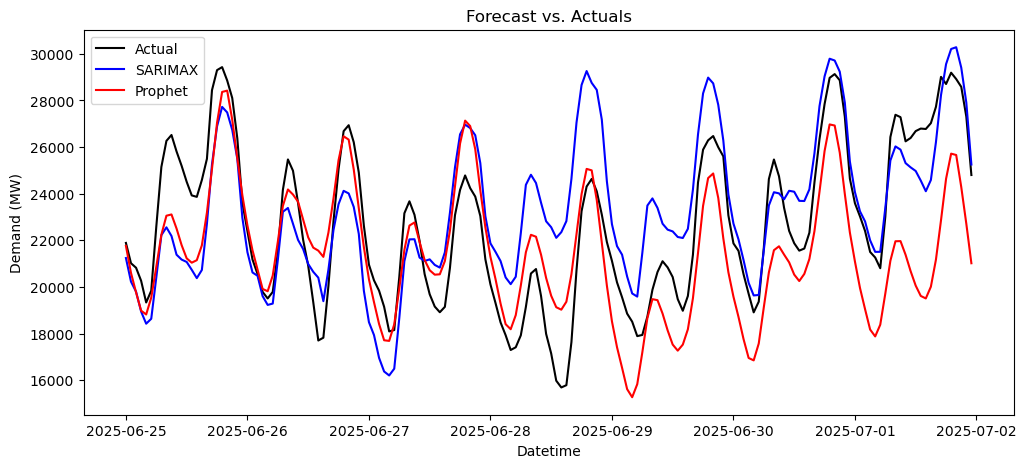

In [43]:
plt.figure(figsize=(12,5))
plt.plot(test.index, test['demand_mw'], label='Actual', color='black')
plt.plot(test.index, test['sarimax_pred'], label='SARIMAX', color='blue')
plt.plot(test_df['ds'], test_df['prophet_pred'], label='Prophet', color='red')
plt.title("Forecast vs. Actuals")
plt.ylabel("Demand (MW)")
plt.xlabel("Datetime")
plt.legend()
plt.show()

In [44]:
results = pd.DataFrame({
    'Model': ['SARIMAX','Prophet'],
    'MAPE (%)': [mape_sarimax*100, mape_prophet*100],
    'RMSE (MW)': [rmse_sarimax, rmse_prophet]
})
results.style.format({'MAPE (%)':'{:.2f}','RMSE (MW)':'{:.1f}'})

,Model,MAPE (%),RMSE (MW)
0,SARIMAX,9.53,2521.8
1,Prophet,9.28,2618.7


## Baseline Model Performance

| Model   | MAPE (%) | RMSE (MW) |
|---------|----------|-----------|
| SARIMAX |   9.53   |   2521.8  |
| Prophet |   9.28   |   2618.7  |

**Interpretation: Forecast vs Actual**

- **SARIMAX (blue):**
  - Captures the **overall daily cycles** in electricity demand relatively well.
  - Tends to **overestimate peak demand**, particularly around June 28th-30th.

- **Prophet (red):**
  - Follows the **general shape and rising trend** but shows **more aggressive peaks**.

- **Actual Demand (black):**
  - Exhibits clear daily seasonality with varying amplitude (e.g., lower peaks on June 28th, a Saturday).

**Implications:**
- **SARIMAX** provides a smoother forecast with better alignment to short-term variability, likely due to the autoregressive terms leveraging recent observations.
- **Prophet** emphasises overall seasonality and trend, which leads to larger errors during unexpected fluctuations or short-term shocks.

## Save Processed Data & Baseline Forecasts

In [45]:
# Merge predictions by datetime
df_results = pd.DataFrame({
    "datetime": test.index,
    "demand_mw": test['demand_mw'].values,
    "sarimax_pred": test['sarimax_pred'].values,
    "prophet_pred": test_df['prophet_pred'].values
})

# Get current timestamp for file naming
stamp = datetime.datetime.now().strftime("%Y%m%d")

os.makedirs(PROCESSED_DIR, exist_ok=True)
df.to_parquet(f"{PROCESSED_DIR}/weather_load_hourly_{stamp}.parquet", index=True)
df_results.to_csv(f"{PROCESSED_DIR}/baseline_forecasts_{stamp}.csv", index=False)

with open(f"{PROCESSED_DIR}/sarimax_summary_{stamp}.txt", "w") as f:
    f.write(res.summary().as_text())

print(f"Outputs saved to '{PROCESSED_DIR}' with timestamp {stamp}.")

Outputs saved to '../data_processed' with timestamp 20250714.


## Baseline Model Results Summary

- **SARIMAX:** MAPE = 9.53%, RMSE = 2521.8 MW
- **Prophet:** MAPE = 9.28%, RMSE = 2618.7 MW

Both models achieve reasonable accuracy for hourly GB demand, given the feature set and data window.  
This sets a solid benchmark for advanced causal modeling in the next notebooks.

## Next Steps
- **Notebook 3:** Causal Impact with BSTS  
- **Notebook 4:** PCMCI causal discovery  